# Data Association


In [3]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
    pass

# Load the TensorBoard notebook extension
%load_ext tensorboard
logdir = './logs/'

# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'

# matplotlib rendering
%matplotlib inline

import sys
sys.path.append("../") # go to parent dir -> for module loading

!pip -q install -r ../requirements.txt

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
You should consider upgrading via the 'pip install --upgrade pip' command.


In [71]:
import os
import random
import itertools

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorboard.plugins.hparams import api as hp
from tensorflow.keras import backend as K
from datetime import datetime
from collections import defaultdict

# custom modules
import data
import model

print('Tensorflow version:', tf.__version__)

print('GPU support:', tf.test.is_gpu_available())
plt.rcParams['figure.figsize'] = [5, 5]

# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

# set all keras layers to use float64
tf.keras.backend.set_floatx('float64')

Tensorflow version: 2.0.0
GPU support: True


In [6]:
from scipy.spatial import distance_matrix
from scipy.optimize import linear_sum_assignment

In [27]:
import importlib
importlib.reload(data)

<module 'data' from '../data.py'>

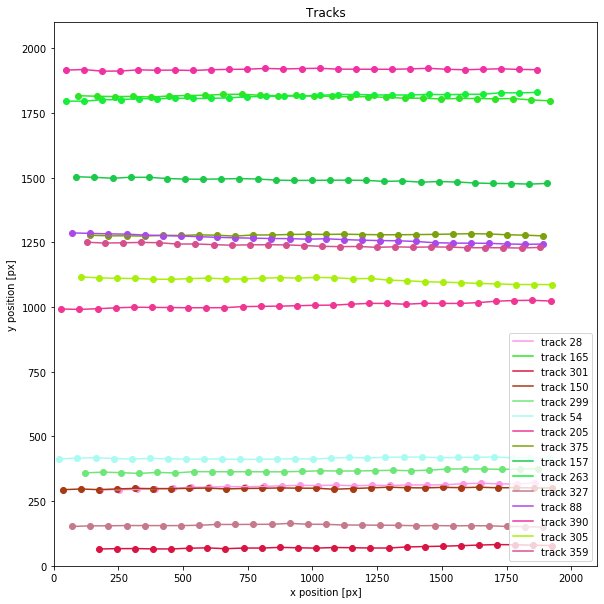

In [38]:
num_time_steps = 350
nan_value = 0
batch_size = 32
belt_width = 2000


dataset = data.FakeDataSet(timesteps=num_time_steps, batch_size=batch_size, number_trajectories=400, 
                           additive_noise_stddev=2, additive_target_stddev=20, belt_width=belt_width,
                          nan_value=nan_value)

dataset_input, dataset_target = dataset.get_seq2seq_data_and_labels(normalized=True)

dataset.plot_random_tracks(n=15)

In [39]:
rnn_model = tf.keras.Sequential()

rnn_model.add(tf.keras.layers.Masking(mask_value=nan_value, name="masking_layer",
                                      batch_input_shape=(batch_size, num_time_steps, 2)))

rnn_model.add(tf.keras.layers.LSTM(16, return_sequences=True, stateful=True, unroll=True))
rnn_model.add(tf.keras.layers.LSTM(16, return_sequences=True, stateful=True, unroll=True))
rnn_model.add(tf.keras.layers.Dense(2))

rnn_model.summary(line_length=120)

Model: "sequential_2"
________________________________________________________________________________________________________________________
Layer (type)                                          Output Shape                                    Param #           
masking_layer (Masking)                               (32, 350, 2)                                    0                 
________________________________________________________________________________________________________________________
lstm_4 (LSTM)                                         (32, 350, 16)                                   1216              
________________________________________________________________________________________________________________________
lstm_5 (LSTM)                                         (32, 350, 16)                                   2112              
________________________________________________________________________________________________________________________
dense_2 (D

In [40]:
# drop remainders of dataset
tracks = dataset_input.shape[0]
max_tracks = (tracks // batch_size) * batch_size

In [41]:
rnn_model.compile(optimizer=tf.optimizers.Adam(), loss='mse')
rnn_model.fit(dataset_input[:max_tracks], dataset_target[:max_tracks], epochs=100, batch_size=batch_size)

Train on 384 samples
Epoch 1/100
384/384 [==============================] - 82s 215ms/sample - loss: 0.0273
Epoch 2/100
384/384 [==============================] - 2s 4ms/sample - loss: 0.0148
Epoch 3/100
384/384 [==============================] - 2s 4ms/sample - loss: 0.0064
Epoch 4/100
384/384 [==============================] - 2s 4ms/sample - loss: 0.0059
Epoch 5/100
384/384 [==============================] - 2s 4ms/sample - loss: 0.0050
Epoch 6/100
384/384 [==============================] - 2s 4ms/sample - loss: 0.0045
Epoch 7/100
384/384 [==============================] - 2s 4ms/sample - loss: 0.0044
Epoch 8/100
384/384 [==============================] - 2s 4ms/sample - loss: 0.0042
Epoch 9/100
384/384 [==============================] - 2s 4ms/sample - loss: 0.0040
Epoch 10/100
384/384 [==============================] - 2s 4ms/sample - loss: 0.0039
Epoch 11/100
384/384 [==============================] - 2s 4ms/sample - loss: 0.0038
Epoch 12/100
384/384 [============================

Epoch 95/100
384/384 [==============================] - 2s 4ms/sample - loss: 1.1844e-04
Epoch 96/100
384/384 [==============================] - 2s 4ms/sample - loss: 1.1578e-04
Epoch 97/100
384/384 [==============================] - 2s 4ms/sample - loss: 1.1143e-04
Epoch 98/100
384/384 [==============================] - 2s 4ms/sample - loss: 1.1151e-04
Epoch 99/100
384/384 [==============================] - 2s 4ms/sample - loss: 1.0912e-04
Epoch 100/100
384/384 [==============================] - 2s 4ms/sample - loss: 1.0346e-04


--------------------------------------------------------------------------------
Time step:  0
prediction_ids []
predictions []
Measurement shape:  (0, 2)


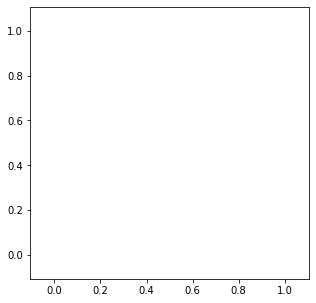

--------------------------------------------------------------------------------
Time step:  1
prediction_ids []
predictions []
Measurement shape:  (0, 2)


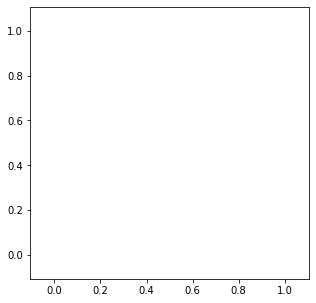

--------------------------------------------------------------------------------
Time step:  2
prediction_ids []
predictions []
Measurement shape:  (1, 2)


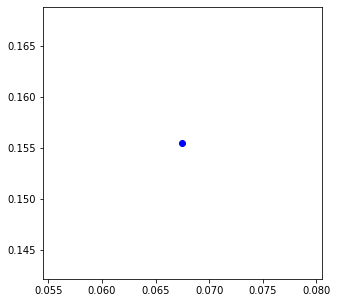

Count new_tracks in 1/10:  1
Count meas. > 9/10:  0
Distances
[[140.]]
Match: 0 0
C
--------------------------------------------------------------------------------
Time step:  3
prediction_ids [0]
predictions [[-0.07196058  0.94600544]]
Measurement shape:  (4, 2)


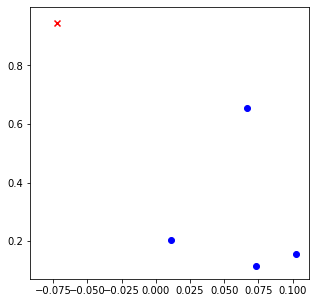

Count new_tracks in 1/10:  3
Count meas. > 9/10:  0
Distances
[[1689.  152.  236. 1093.]
 [1492.  183.   27.  901.]
 [1620.  225.  232. 1022.]
 [ 645. 1091.  912.  139.]]
Match: 0 1
C
Match: 1 2
C
Match: 2 3
C
Match: 3 0
A


KeyError: 0

In [92]:
# create the model manager
model_manager = model.ModelManager(dataset_input.shape[0], batch_size, rnn_model)

TIME_STEPS = num_time_steps
MAX_NUM_TRAJECTORIES = dataset_input.shape[0]
SIZE_X = 1.
SIZE_Y = 1.
# the region, where the track is considered to appear / disappear
X_DETECTION_TOLERANCE = SIZE_X / 10.

# the distance of the pseudo measurements and tracks to the actual belt
X_THRESHOLD = 5./2000.

# generate increasing ids
def id_generator():
    n = 0
    while True:
        yield n
        n += 1

all_ids = []

# id => mm_id
mm_track_ids = {}

# id => list(observations)
track_history = defaultdict(list)

active_ids = set()

for time_step in range(num_time_steps):
    print('-'*80)
    print('Time step: ', time_step)
    predictions_ids = [mm_track_ids[i] for i in sorted(active_ids)]
    print("prediction_ids", predictions_ids)
    predictions = model_manager.predict()
    
    predictions_mask = np.zeros(predictions.shape[0], dtype=np.bool)
    predictions_mask[predictions_ids] = True
    
    predictions = predictions[predictions_mask]
    print("predictions", predictions)
    
    
    measurements = dataset.get_measurement_at_timestep(time_step)
    mask = np.any(measurements != [nan_value, nan_value], axis=-1)
    measurements = measurements[mask]
    print('Measurement shape: ', measurements.shape)
    
    plt.scatter(predictions[:, 0], predictions[:, 1], marker='x', c='red', label='measurement')
    plt.scatter(measurements[:, 0], measurements[:, 1], c='blue', label='measurement')
    plt.show()
    
    if measurements.shape[0] == 0:
        continue
    
    # 1. particle enters perception: add an artificial track for every measurement at the first 1/10 of the belt
    #   -> for every of these tracks: create an artificial measurement
    mask_new_tracks = measurements[:, 0] < X_DETECTION_TOLERANCE
    count_new_tracks = np.sum(mask_new_tracks)
    
    artificial_predictions = np.stack((np.ones(count_new_tracks)*-X_THRESHOLD,
                                        measurements[mask_new_tracks][:, 1]), axis=-1)
    print('Count new_tracks in 1/10: ', count_new_tracks)
    
    # 2. particle leaves perception: the predicted particles which are in the terminal region of the belt
    mask_end_measurements = predictions[:, 0] > SIZE_X - X_DETECTION_TOLERANCE
    count_end_measurements = np.sum(mask_end_measurements)
    artificial_measurements = np.stack((np.ones(count_end_measurements)*(SIZE_X + X_THRESHOLD),
                                        predictions[mask_end_measurements][:, 1]), axis=-1)
    print('Count meas. > 9/10: ', count_end_measurements)
    
    # Distance matrix
    all_measurements = np.concatenate((measurements, artificial_measurements)) * 2000
    all_predictions = np.concatenate((predictions, artificial_predictions)) * 2000
    distances = distance_matrix(all_measurements, all_predictions)
    
    with np.printoptions(precision=0, suppress=True):
        print("Distances")
        print(distances)
        
    measurement_assignment_ids, prediction_assignment_ids  = linear_sum_assignment(distances)
    
    # Different cases
    #    A | B
    #    -----
    #    C | D
    for measurement_id, prediction_id in zip(measurement_assignment_ids.tolist(), 
                                             prediction_assignment_ids.tolist()):
        print('Match:', measurement_id, prediction_id)
        # A) measurement <-> existing prediction   => add measurement as new observation of the track
        if measurement_id < measurements.shape[0] and prediction_id < predictions.shape[0]:
            print('A')
            id_ = predictions_ids[prediction_id]
            mm_track_id = mm_track_ids[id_]
            model_manager.set_track_measurement(mm_track_id, all_measurements[measurement_id])
            # store observation
            track_history[id_].append([time_step, all_measurements[measurement_id]])
            
        # B) artificial measurement <-> prediction  => delete track
        elif measurement_id >= measurements.shape[0] and prediction_id < predictions.shape[0]:
            print('B')
            id_ = predictions_ids[prediction_id]
            active_ids.remove(id_)
            mm_track_id = mm_track_ids[id_]
            model_manager.free(mm_track_id)
            
        # C) measurement <-> artificial prediction  => create track     
        elif measurement_id < measurements.shape[0] and prediction_id >= predictions.shape[0]:
            print('C')
            # new global id
            id_ = id_generator()
            active_ids.add(id_)
            # new model manger id
            mm_track_id = model_manager.allocate_track()
            mm_track_ids[id_] = mm_track_id
            model_manager.set_track_measurement(mm_track_id, all_measurements[measurement_id])
            # store observation
            track_history[id_].append([time_step, all_measurements[measurement_id]])
        
        # D) artificial measurement <-> artificial prediction   => do nothing
        elif measurement_id >= measurements.shape[0] and prediction_id >= predictions.shape[0]:
            print('D')    
    
    

In [63]:
matching_indices

(array([0]), array([0]))

In [62]:
b

array([0])